**Extract data from Azure**

In [0]:
# !pip install azure.datalake.store

In [0]:
from azure.datalake.store import core, lib, multithread
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


In [0]:
tenant_id = "e8e22e33-4f8e-4fc5-b212-0964c3753906"
username = 'email'
password = "password"
store_name = "nus"
token = lib.auth(tenant_id, username, password)
adl = core.AzureDLFileSystem(token, store_name=store_name)

In [0]:
with adl.open('nus2020team02/2017/01/15/ais_southern_ships_2017_01_zone15_reduce.csv', 'rb') as f:
    df = pd.read_csv(f)

**Label ship types**

In [0]:
vessel_info_df = pd.read_csv('/Users/celinelim/Downloads/DSA4261/Bunker-Fraud/extra_data/VesselTypeCodes.csv')
vessel_info_dict = {}
for i in range(0,len(vessel_info_df)):
    vesselcode = float(vessel_info_df['VesselType'][i])
    vesselgroup = vessel_info_df['VesselGroup'][i]
    vessel_info_dict[vesselcode] = vesselgroup

df['VesselType_New'] = df['VesselType'].map(vessel_info_dict)

In [0]:
# Remove VesselType_New with nan
df = df[~pd.isnull(df.VesselType_New)]

In [0]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,VesselType_New
0,367715380,2017-01-01T00:10:48.0000000Z,3.23338,-90.36520,8.9,169.0,168.0,LOREE ECKSTEIN,NaN,WDI6112,1025.0,undefined,NaN,NaN,NaN,NaN,Tug Tow
1,372902000,2017-01-01T22:59:34.0000000Z,18.56283,-93.42249,0.0,193.6,511.0,WEST COURAGEOUS,IMO8768452,HO3102,1007.0,reserved for future use (9),74.06,62.79,NaN,90.0,Other
2,372902000,2017-01-01T23:00:54.0000000Z,18.56314,-93.42236,0.0,190.1,511.0,WEST COURAGEOUS,IMO8768452,HO3102,1007.0,reserved for future use (9),74.06,62.79,NaN,90.0,Other
3,372902000,2017-01-01T23:02:24.0000000Z,18.56309,-93.42242,0.0,184.1,511.0,WEST COURAGEOUS,IMO8768452,HO3102,1007.0,reserved for future use (9),74.06,62.79,NaN,90.0,Other
4,220559000,2017-01-02T01:16:40.0000000Z,20.87767,-95.87183,13.2,0.0,0.0,TORM RHONE,IMO9215086,OYNR2,1024.0,under way using engine,183.00,27.40,11.0,NaN,Tanker


Filter the possible vessels that can be bunkers

In [0]:
# df = df[((df.VesselType>=80) & (df.VesselType<=89)) | (df.VesselType==1024) | (df.VesselType==1017)]

Find time difference (observation gap) distribution

In [0]:
basedatetime_utc = df['BaseDateTime'].apply(lambda x: datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.0000000Z'))
df['BaseDateTime_UTC'] = basedatetime_utc
df['Date'] = df['BaseDateTime'].apply(lambda x:x[:10])

In [0]:
def time_diff_in_seconds(t1,t2):
    if t1 > t2:
        diff = (t1 - t2).total_seconds()
    elif t2 > t1:
        diff = (t2 - t1).total_seconds()
    elif t2 == t1:
        diff = 0
    return diff

In [0]:
mmsis = df['MMSI'].unique().tolist()
groupings = df.groupby('MMSI')
new_df = pd.DataFrame()
for mm in mmsis:
    group = groupings.get_group(mm).reset_index(drop=True)
    group['TimeDiff'] = np.zeros(len(group))
    for j in range(1,len(group)):
        t1 = group['BaseDateTime_UTC'][j]
        t2 = group['BaseDateTime_UTC'][j-1]
        td = time_diff_in_seconds(t1,t2)
        group['TimeDiff'][j] = td
    new_df = pd.concat([new_df,group],axis=0)

/Users/celinelim/opt/anaconda3/envs/movingpandas/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [0]:
new_df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,VesselType_New,BaseDateTime_UTC,Date,TimeDiff
0,367715380,2017-01-01T00:10:48.0000000Z,3.23338,-90.36520,8.9,169.0,168.0,LOREE ECKSTEIN,NaN,WDI6112,1025.0,undefined,NaN,NaN,NaN,NaN,Tug Tow,2017-01-01 00:10:48,2017-01-01,0.0
1,367715380,2017-01-05T00:04:42.0000000Z,15.12282,-90.11835,11.2,-107.6,309.0,LOREE ECKSTEIN,NaN,WDI6112,1025.0,undefined,NaN,NaN,NaN,NaN,Tug Tow,2017-01-05 00:04:42,2017-01-05,345234.0
2,367715380,2017-01-05T00:07:56.0000000Z,3.84523,-90.12875,11.6,1.1,290.0,LOREE ECKSTEIN,NaN,WDI6112,1025.0,undefined,NaN,NaN,NaN,NaN,Tug Tow,2017-01-05 00:07:56,2017-01-05,194.0
3,367715380,2017-01-05T00:46:47.0000000Z,3.04722,-90.18592,11.2,-200.0,223.0,LOREE ECKSTEIN,NaN,WDI6112,1025.0,undefined,NaN,NaN,NaN,NaN,Tug Tow,2017-01-05 00:46:47,2017-01-05,2331.0
4,367715380,2017-01-05T00:55:00.0000000Z,3.84492,-90.20598,11.1,-183.8,234.0,LOREE ECKSTEIN,NaN,WDI6112,1025.0,undefined,NaN,NaN,NaN,NaN,Tug Tow,2017-01-05 00:55:00,2017-01-05,493.0


In [0]:
df = new_df

**Creating trajectories**

In [0]:
from geopandas import GeoDataFrame, read_file
from shapely.geometry import Point, LineString, Polygon
from fiona.crs import from_epsg
import movingpandas as mpd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

Output hidden; open in https://colab.research.google.com to view.

Create point geometries for each point in the dataset


In [0]:
geometry = [Point(xy) for xy in zip(df['LON'],df['LAT'])]

In [0]:
crs = from_epsg(31256) 
df['t'] = pd.to_datetime(df['BaseDateTime'],format='%Y-%m-%dT%H:%M:%S.0000000Z')
df = df.set_index('t')
df= df.rename(columns={"LAT":"Latitude","LON":"Longitude"})
geo_df = GeoDataFrame(df, crs=crs)
geo_df['geometry'] = geometry

In [0]:
geo_df.head(2)

,MMSI,BaseDateTime,Latitude,Longitude,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,VesselType_New,BaseDateTime_UTC,Date,TimeDiff,geometry
t,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:10:48,367715380,2017-01-01T00:10:48.0000000Z,3.23338,-90.36520,8.9,169.0,168.0,LOREE ECKSTEIN,NaN,WDI6112,...,undefined,NaN,NaN,NaN,NaN,Tug Tow,2017-01-01 00:10:48,2017-01-01,0.0,POINT (-90.36520 3.23338)
2017-01-05 00:04:42,367715380,2017-01-05T00:04:42.0000000Z,15.12282,-90.11835,11.2,-107.6,309.0,LOREE ECKSTEIN,NaN,WDI6112,...,undefined,NaN,NaN,NaN,NaN,Tug Tow,2017-01-05 00:04:42,2017-01-05,345234.0,POINT (-90.11835 15.12282)


In [0]:
MIN_LENGTH = 2 # meters
traj_collection = mpd.TrajectoryCollection(geo_df, 'MMSI', min_length=MIN_LENGTH)
print("Finished creating {} trajectories".format(len(traj_collection)))

Finished creating 120 trajectories


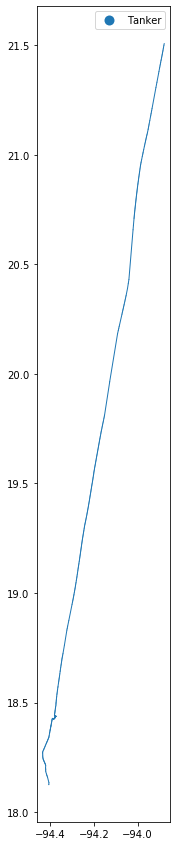

In [0]:
traj_collection.trajectories[7].plot(column='VesselType_New', linewidth=1, capstyle='round',legend=True,figsize=(15,15))

In [0]:
trajectories = traj_collection.trajectories
trips = traj_collection.split_by_observation_gap(timedelta(minutes=13))
print("Extracted {} individual trips from {} continuous vessel tracks".format(len(trips), len(trajectories)))

Extracted 30 individual trips from 120 continuous vessel tracks


Extracting sub-trajectories from trajectories

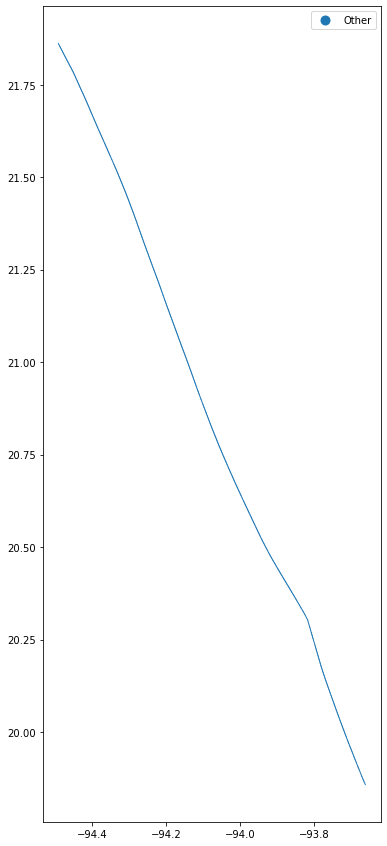

In [0]:
trips.trajectories[9].plot(column='VesselType_New', linewidth=1, capstyle='round',legend=True,figsize=(15,15)) #5 looks like a bunker

In [0]:
trips.trajectories[9].df

,MMSI,BaseDateTime,Latitude,Longitude,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,VesselType_New,BaseDateTime_UTC,Date,TimeDiff,geometry
t,,,,,,,,,,,,,,,,,,,,,
2017-01-21 17:00:22,345010043,2017-01-21T17:00:22.0000000Z,21.86160,-94.49067,9.3,155.2,151.0,XICALANGO,IMO9357157,XCHW7,...,under way using engine,73.2,16.5,5.6,39.0,Other,2017-01-21 17:00:22,2017-01-21,0.0,POINT (-94.49067 21.86160)
2017-01-21 17:03:50,345010043,2017-01-21T17:03:50.0000000Z,21.85322,-94.48636,9.7,155.1,151.0,XICALANGO,IMO9357157,XCHW7,...,under way using engine,73.2,16.5,5.6,39.0,Other,2017-01-21 17:03:50,2017-01-21,208.0,POINT (-94.48636 21.85322)
2017-01-21 17:04:51,345010043,2017-01-21T17:04:51.0000000Z,21.85075,-94.48508,9.7,154.9,153.0,XICALANGO,IMO9357157,XCHW7,...,under way using engine,73.2,16.5,5.6,39.0,Other,2017-01-21 17:04:51,2017-01-21,61.0,POINT (-94.48508 21.85075)
2017-01-21 17:06:20,345010043,2017-01-21T17:06:20.0000000Z,21.84716,-94.48323,9.6,154.8,153.0,XICALANGO,IMO9357157,XCHW7,...,under way using engine,73.2,16.5,5.6,39.0,Other,2017-01-21 17:06:20,2017-01-21,89.0,POINT (-94.48323 21.84716)
2017-01-21 17:08:11,345010043,2017-01-21T17:08:11.0000000Z,21.84262,-94.48089,9.7,153.7,151.0,XICALANGO,IMO9357157,XCHW7,...,under way using engine,73.2,16.5,5.6,39.0,Other,2017-01-21 17:08:11,2017-01-21,111.0,POINT (-94.48089 21.84262)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-22 05:53:41,345010043,2017-01-22T05:53:41.0000000Z,19.90018,-93.67812,8.8,159.8,169.0,XICALANGO,IMO9357157,XCHW7,...,under way using engine,73.2,16.5,5.6,39.0,Other,2017-01-22 05:53:41,2017-01-22,120.0,POINT (-93.67812 19.90018)
2017-01-22 06:02:03,345010043,2017-01-22T06:02:03.0000000Z,19.88045,-93.67019,9.3,159.4,168.0,XICALANGO,IMO9357157,XCHW7,...,under way using engine,73.2,16.5,5.6,39.0,Other,2017-01-22 06:02:03,2017-01-22,502.0,POINT (-93.67019 19.88045)
2017-01-22 06:05:42,345010043,2017-01-22T06:05:42.0000000Z,19.87184,-93.66666,9.1,159.0,168.0,XICALANGO,IMO9357157,XCHW7,...,under way using engine,73.2,16.5,5.6,39.0,Other,2017-01-22 06:05:42,2017-01-22,219.0,POINT (-93.66666 19.87184)


Plotting all trajectories (all the points of a ship from start to end in the data)

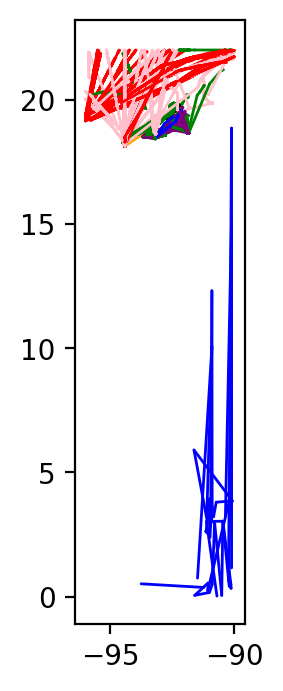

In [0]:
plt.rcParams['figure.dpi'] = 200
shiptype_to_color1 = {'Tug Tow': 'blue', 'Other': 'green', 'Tanker': 'pink', 'Cargo': 'red', 'Pleasure Craft/Sailing': 'yellow', 'Passenger':'purple', 'Fishing':'black', 'Not Available': 'orange'}
traj_collection.plot(column='VesselType_New', column_to_color=shiptype_to_color1, linewidth=1, capstyle='round', figsize=(20,10))

In our data, trip origins can be:

When a ship departs its anchoring location and the speed changes from 0 to >0
When a ship trajectory first enters the observation area

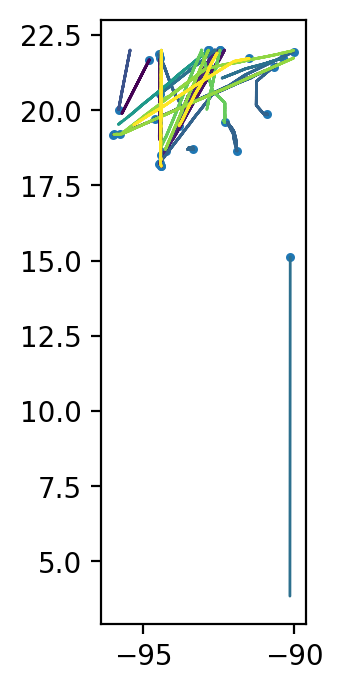

In [0]:
origins = trips.get_start_locations(['SOG', 'VesselType_New'])
trips.plot(column='MMSI', linewidth=1, capstyle='round', figsize=(20,10))
plt.scatter(origins.geometry.x, origins.geometry.y, s=5)

In [0]:
traj_collection.trajectories[12].df


,MMSI,BaseDateTime,Latitude,Longitude,SOG,COG,Heading,VesselName,IMO,CallSign,...,Status,Length,Width,Draft,Cargo,VesselType_New,BaseDateTime_UTC,Date,TimeDiff,geometry
t,,,,,,,,,,,,,,,,,,,,,
2017-01-21 15:52:43,235077605,2017-01-21T15:52:43.0000000Z,21.98403,-94.44520,14.7,180.0,180.0,PIGEON POINT,IMO9322396,2DBR8,...,under way using engine,185.99,32.23,12.1,NaN,Tanker,2017-01-21 15:52:43,2017-01-21,0.0,POINT (-94.44520 21.98403)
2017-01-21 15:58:08,235077605,2017-01-21T15:58:08.0000000Z,21.96142,-94.44565,14.7,180.0,180.0,PIGEON POINT,IMO9322396,2DBR8,...,under way using engine,185.99,32.23,12.1,NaN,Tanker,2017-01-21 15:58:08,2017-01-21,325.0,POINT (-94.44565 21.96142)
2017-01-21 15:59:31,235077605,2017-01-21T15:59:31.0000000Z,21.95545,-94.44575,14.6,181.0,181.0,PIGEON POINT,IMO9322396,2DBR8,...,under way using engine,185.99,32.23,12.1,NaN,Tanker,2017-01-21 15:59:31,2017-01-21,83.0,POINT (-94.44575 21.95545)
2017-01-21 16:17:07,235077605,2017-01-21T16:17:07.0000000Z,21.88377,-94.44712,14.5,180.0,180.0,PIGEON POINT,IMO9322396,2DBR8,...,under way using engine,185.99,32.23,12.1,NaN,Tanker,2017-01-21 16:17:07,2017-01-21,1056.0,POINT (-94.44712 21.88377)
2017-01-21 16:25:49,235077605,2017-01-21T16:25:49.0000000Z,21.84833,-94.44790,14.5,180.0,180.0,PIGEON POINT,IMO9322396,2DBR8,...,under way using engine,185.99,32.23,12.1,NaN,Tanker,2017-01-21 16:25:49,2017-01-21,522.0,POINT (-94.44790 21.84833)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-25 15:55:16,235077605,2017-01-25T15:55:16.0000000Z,21.98132,-92.31222,14.7,24.0,28.0,PIGEON POINT,IMO9322396,2DBR8,...,under way using engine,185.99,32.23,12.1,NaN,Tanker,2017-01-25 15:55:16,2017-01-25,66.0,POINT (-92.31222 21.98132)
2017-01-25 15:56:22,235077605,2017-01-25T15:56:22.0000000Z,21.98553,-92.31008,14.6,25.0,27.0,PIGEON POINT,IMO9322396,2DBR8,...,under way using engine,185.99,32.23,12.1,NaN,Tanker,2017-01-25 15:56:22,2017-01-25,66.0,POINT (-92.31008 21.98553)
2017-01-25 15:57:27,235077605,2017-01-25T15:57:27.0000000Z,21.98942,-92.30818,14.5,25.0,27.0,PIGEON POINT,IMO9322396,2DBR8,...,under way using engine,185.99,32.23,12.1,NaN,Tanker,2017-01-25 15:57:27,2017-01-25,65.0,POINT (-92.30818 21.98942)


In [0]:
single_traj = traj_collection.trajectories[12].df
# single_traj[single_traj.SOG==0]
plt.plot(single_traj.Longitude, single_traj.Latitude)
plt.scatter(single_traj[single_traj.SOG==0].Longitude, single_traj[single_traj.SOG==0].Latitude, s=5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Full Trajectory of Vessel 345030016')
plt.text(-90.7, 19.8, 'Origin')


**Fast DTW (Dynamic Time Warping for Time Series) Similarity between trajectories**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5579835/

* DTW is easier to find the shape similarity of the trajectory, and is warping the route from feature to feature. Therefore, DTW is chosen as the similarity measurement method in this work to calculate the distances between trajectories.

In [0]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from joblib import Parallel, delayed
import itertools
import seaborn as sns
%matplotlib inline

In [0]:
trajectories[0].df

,MMSI,BaseDateTime,Latitude,Longitude,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,VesselType_New,BaseDateTime_UTC,TimeDiff,geometry
t,,,,,,,,,,,,,,,,,,,,
2017-01-24 08:27:12,0,2017-01-24T08:27:12.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,0.0,0.0,Not Available,2017-01-24 08:27:12,0.0,POINT (-94.41903 18.12518)
2017-01-24 08:29:42,0,2017-01-24T08:29:42.0000000Z,18.12518,-94.41903,0.0,-195.6,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,Not Available,2017-01-24 08:29:42,150.0,POINT (-94.41903 18.12518)
2017-01-24 08:47:42,0,2017-01-24T08:47:42.0000000Z,18.12518,-94.41903,0.0,-195.7,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,Not Available,2017-01-24 08:47:42,1080.0,POINT (-94.41903 18.12518)
2017-01-24 09:05:21,0,2017-01-24T09:05:21.0000000Z,18.12519,-94.41902,0.0,-195.4,214.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,Not Available,2017-01-24 09:05:21,1059.0,POINT (-94.41902 18.12519)
2017-01-24 20:56:52,0,2017-01-24T20:56:52.0000000Z,18.79671,-93.43659,11.8,58.5,59.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,Not Available,2017-01-24 20:56:52,42691.0,POINT (-93.43659 18.79671)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-25 19:44:22,0,2017-01-25T19:44:22.0000000Z,18.89345,-92.49724,1.1,-181.6,3.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,Not Available,2017-01-25 19:44:22,130.0,POINT (-92.49724 18.89345)
2017-01-25 19:45:32,0,2017-01-25T19:45:32.0000000Z,18.89326,-92.49750,0.9,-172.3,359.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,Not Available,2017-01-25 19:45:32,70.0,POINT (-92.49750 18.89326)
2017-01-25 19:47:53,0,2017-01-25T19:47:53.0000000Z,18.89311,-92.49802,1.0,-125.8,349.0,NaN,NaN,NaN,0.0,undefined,0.0,0.0,3.0,0.0,Not Available,2017-01-25 19:47:53,141.0,POINT (-92.49802 18.89311)


In [0]:
# https://github.com/slaypni/fastdtw/pull/29
traj_len = len(trajectories)
trajectories_list = [trajectories[i].df for i in range(traj_len)]
results = Parallel(n_jobs=-1)(delayed(fastdtw)(trajectories_list[i][['Longitude', 'Latitude', 'SOG', 'COG', 'TimeDiff']], trajectories_list[j][['Longitude', 'Latitude', 'SOG', 'COG', 'TimeDiff']]) for i, j in itertools.product(range(traj_len), repeat=2))
distance_mat = np.array([r[0] for r in results]).reshape(traj_len, traj_len)
distance_mat.shape

(120, 120)

In [0]:
def convert_mat_to_df(distance_mat):
  """
  Input: Distance matrix, nxn
  Output: Pandas DataFrame with all possible choose(n, 2) trajectory pairs and the distance between each pair
  """
  distance_df = pd.DataFrame(distance_mat)
  distance_df = distance_df.where(np.triu(np.ones(distance_mat.shape)).astype(np.bool))
  distance_df = distance_df.stack().reset_index()
  distance_df.columns = ['Row','Column','Distance'] 
  distance_df = distance_df[distance_df.Row != distance_df.Column] # Remove same traj distances on the diagonal
  return distance_df

distance_df = convert_mat_to_df(distance_mat)
distance_df

,Row,Column,Distance
1,0,1,1.572433e+05
2,0,2,4.055847e+05
3,0,3,4.748553e+05
4,0,4,1.779703e+05
5,0,5,2.073261e+06
...,...,...,...
7252,116,118,8.568390e+04
7253,116,119,5.924027e+05
7255,117,118,1.564933e+05
7256,117,119,6.022282e+05


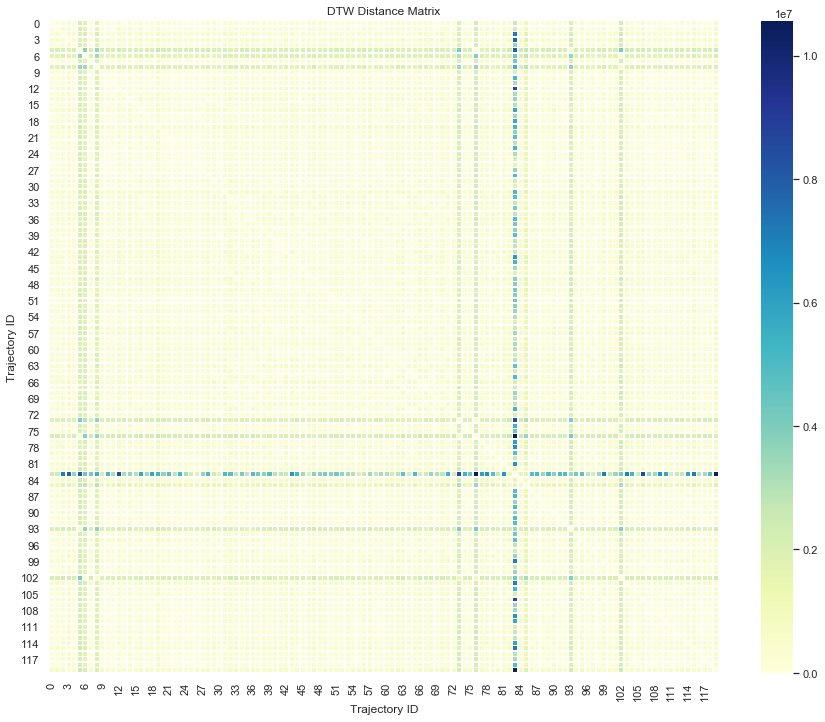

In [0]:
plt.figure(figsize=(15,12))
ax = sns.heatmap(distance_mat, linewidth=0.5, cmap="YlGnBu")
plt.xlabel('Trajectory ID')
plt.ylabel('Trajectory ID')
plt.title('DTW Distance Matrix')
plt.savefig('/Users/celinelim/Downloads/DSA4261/Bunker-Fraud/codes/dtw_matrix.png', dpi=200)

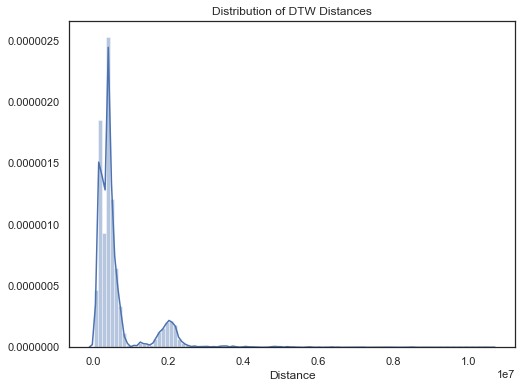

In [0]:
plt.figure(figsize=(8, 6))
sns.set(style='white')
sns.distplot(distance_df.Distance, bins=100, norm_hist=True);
plt.title("Distribution of DTW Distances")
plt.savefig('/Users/celinelim/Downloads/DSA4261/Bunker-Fraud/codes/dtw_dist.png', dpi=200)

**DBSCAN (Using the DTW Distance Matrix)**
Alternative method to find anomalies.

In [0]:
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.neighbors import NearestNeighbors
# pull out the only the location metrics

eps_list = np.arange(50000, 2000000, 50000).tolist()
perc_anomaly = []
for eps in eps_list:
  kms_per_radian = 6371.0088
  epsilon = 2 / kms_per_radian
  db = DBSCAN(eps=eps, min_samples=5, metric='precomputed')   
  pred = db.fit_predict(distance_mat)
  perc_anomaly.append((len(pred[pred==-1])/len(pred))*100)

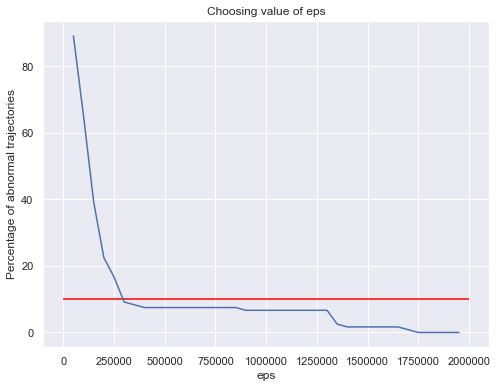

In [0]:
sns.set(style='darkgrid')
plt.figure(figsize=(8, 6))
sns.lineplot(eps_list, perc_anomaly)
plt.hlines(10, 0, 2000000, colors='red')
plt.xlabel('eps')
plt.ylabel('Percentage of abnormal trajectories')
plt.title('Choosing value of eps')
plt.savefig('/Users/celinelim/Downloads/DSA4261/Bunker-Fraud/codes/optimal_eps.png', dpi=200)

In [0]:
db = DBSCAN(eps=300000, min_samples=5, metric='precomputed')   #47000
pred = db.fit_predict(distance_mat)
perc_anomaly.append(len(pred[pred==-1])/len(pred))

In [0]:
pred

array([ 0,  0,  0,  0,  0, -1, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1,  0,
       -1,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
       -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1])

In [0]:
len(pred[pred==-1])/len(pred)

0.09166666666666666

In [0]:
[index for index,value in enumerate(pred) if value == 0]

[0,
 1,
 2,
 3,
 4,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118]

In [0]:
trajectories[26].df

,MMSI,BaseDateTime,Latitude,Longitude,SOG,COG,Heading,VesselName,IMO,CallSign,...,Width,Draft,Cargo,VesselType_New,BaseDateTime_UTC,Date,TimeDiff,geometry,traj_id,cluster
t,,,,,,,,,,,,,,,,,,,,,
2017-01-21 02:01:20,311727000,2017-01-21T02:01:20.0000000Z,18.83741,-93.26331,13.5,20.7,29.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 02:01:20,2017-01-21,0.0,POINT (-93.26331 18.83741),26,0
2017-01-21 02:04:29,311727000,2017-01-21T02:04:29.0000000Z,18.84807,-93.25801,13.4,26.7,30.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 02:04:29,2017-01-21,189.0,POINT (-93.25801 18.84807),26,0
2017-01-21 02:06:09,311727000,2017-01-21T02:06:09.0000000Z,18.85365,-93.25507,13.3,26.7,30.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 02:06:09,2017-01-21,100.0,POINT (-93.25507 18.85365),26,0
2017-01-21 02:08:00,311727000,2017-01-21T02:08:00.0000000Z,18.85978,-93.25180,13.3,26.5,30.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 02:08:00,2017-01-21,111.0,POINT (-93.25180 18.85978),26,0
2017-01-21 02:09:09,311727000,2017-01-21T02:09:09.0000000Z,18.86362,-93.24982,13.3,26.2,30.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 02:09:09,2017-01-21,69.0,POINT (-93.24982 18.86362),26,0
2017-01-21 02:12:00,311727000,2017-01-21T02:12:00.0000000Z,18.87307,-93.24485,13.3,26.6,30.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 02:12:00,2017-01-21,171.0,POINT (-93.24485 18.87307),26,0
2017-01-21 02:34:40,311727000,2017-01-21T02:34:40.0000000Z,18.94882,-93.20537,13.4,26.6,30.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 02:34:40,2017-01-21,1360.0,POINT (-93.20537 18.94882),26,0
2017-01-21 09:40:47,311727000,2017-01-21T09:40:47.0000000Z,20.69504,-93.47233,16.0,-56.0,352.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 09:40:47,2017-01-21,25567.0,POINT (-93.47233 20.69504),26,0
2017-01-21 09:41:48,311727000,2017-01-21T09:41:48.0000000Z,20.69953,-93.47286,16.0,-55.7,352.0,HELGA SPIRIT,IMO9292503,C6FZ3,...,43.8,14.9,80.0,Tanker,2017-01-21 09:41:48,2017-01-21,61.0,POINT (-93.47286 20.69953),26,0


In [0]:
df_clusters = []
for i in range(len(trajectories)):
  temp = trajectories[i].df
  temp['traj_id'] = i
  temp['cluster'] = pred[i]

  df_clusters.append(temp)

df_clusters = pd.concat(df_clusters)

In [0]:
df_clusters.to_csv('/Users/celinelim/Downloads/DSA4261/Bunker-Fraud/codes/dbscan_20170115_eps300000.csv')

**PCA Decomposition on the DTW Distance Matrix**
* The number of clusters can be obtained by selecting the top k principal components whose accumulative contribution rate is greater than 95%.

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler(feature_range=[0, 1])
distance_mat_rescaled = scaler.fit_transform(distance_mat)

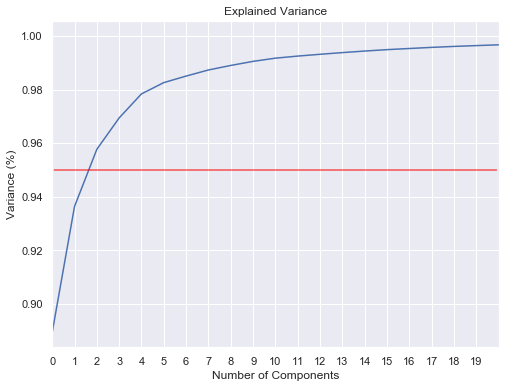

In [0]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(distance_mat_rescaled)

#Plotting the Cumulative Summation of the Explained Variance
sns.set_style("darkgrid")
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.annotate("",
              xy=(0, 0.95), xycoords='data',
              xytext=(20, 0.95), textcoords='data',
              arrowprops=dict(arrowstyle="-",
                              connectionstyle="arc3,rad=0.",
                              edgecolor = "red"), 
              )
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.xlim([0, 20])
plt.xticks(list(range(20)))
plt.savefig('/Users/celinelim/Downloads/DSA4261/Bunker-Fraud/codes/pca_variance.png', dpi=200)
plt.show()

In [0]:
k = 5
pca = PCA(n_components=k)
distance_mat_pca = pca.fit_transform(distance_mat_rescaled) # our new data

**Improved Center Clustering Algorithm**


In [0]:
from scipy.special import comb

In [0]:
def calc_mean_dist(distance_mat):
  """
  Input: Distance matrix, nxn
  Output: Returns the mean of all possible choose(n, 2) pairs of distances.
  """
  return np.sum(np.triu(distance_mat))/comb(distance_mat.shape[0], 2)

def convert_mat_to_df(distance_mat):
  """
  Input: Distance matrix, nxn
  Output: Pandas DataFrame with all possible choose(n, 2) trajectory pairs and the distance between each pair
  """
  distance_df = pd.DataFrame(distance_mat)
  distance_df = distance_df.where(np.triu(np.ones(distance_mat.shape)).astype(np.bool))
  distance_df = distance_df.stack().reset_index()
  distance_df.columns = ['Row','Column','Distance'] 
  distance_df = distance_df[distance_df.Row != distance_df.Column] # Remove same traj distances on the diagonal
  return distance_df

def calc_v_avg_single(id, trajectories_list):
  """
  Input: Trajectory index and list of trajectory DataFrames
  Output: Mean speed of all points in a single trajectory
  """
  return np.mean(trajectories_list[id].SOG)

def calc_v_avg_pair(id1, id2, trajectories_list):
  """
  Input: 2 trajector indices and list of trajectory DataFrames
  Output: Average of the 2 mean speeds 
  """
  mean1 = calc_v_avg_single(id1, trajectories_list)
  mean2 = calc_v_avg_single(id2, trajectories_list)
  return (mean1+mean2)/2

def calc_v_avg_overall(distance_df, trajectories_list):
  """
  Input: Distance DataFrame and list of trajectory DataFrames (length n)
  Output: Average speed for all choose(n, 2) combinations of trajectories
  """
  v = []
  for idx, l in distance_df.iterrows():
    v.append(calc_v_avg_pair(int(l['Row']), int(l['Column']), trajectories_list)) 
  return sum(v)/len(v)


In [0]:
def ICC_cluster(sorted_distance_df, trajectories_list, thr):
  traj_id = [0]*len(trajectories_list)
  v_avg = calc_v_avg_overall(distance_df, trajectories_list)

  for idx, l in sorted_distance_df.iterrows():
    if l['Difference'] > thr:
      SOG1 = calc_v_avg_single(l['Row'])
      SOG2 = calc_v_avg_single(l['Column'])

      # COG

      if SOG1 == 0 or SOG1 < 2*v_avg: # or COG:
        traj_id[int(l['Row'])] = 1 # anomalous as 1

      if SOG2 == 0 or SOG2 < 2*v_avg: # or COG:
        traj_id[int(l['Column'])] = 1 # anomalous
    else:
      traj_id[int(l['Row'])] = 0 # normal
      traj_id[int(l['Column'])] = 1

  return traj_id

    

In [0]:
thr = calc_mean_dist(distance_mat)
distance_df = convert_mat_to_df(distance_mat)
sorted_distance_df = distance_df.sort_values(by='Distance', ascending=False)
sorted_distance_df['Difference'] = sorted_distance_df.Distance.diff(periods=-1)
sorted_distance_df.head()
anomalous_id = ICC_cluster(sorted_distance_df, trajectories_list, thr)
anomalous_id

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [0]:
anomalous_traj = [trajectories_list[index] for index, indicator in enumerate(anomalous_id) if indicator==1]
# len(trajectories_list)

In [0]:
lines = [traj_collection.trajectories[i].to_linestring() for i in range(len(trajectories_list))]
lines

In [0]:
list(traj_collection.trajectories[0].to_linestring().coords)

In [0]:
from shapely.geometry import mapping
import fiona

schema = {
    'geometry': 'LineString',
    'properties': {'id': 'int', 'anomaly':'int'},
}

# Write a new Shapefile
with fiona.open('tankers_traj.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here

    for i in range(len(trajectories_list)):
      c.write({
          'geometry': mapping(lines[i]),
          'properties': {'id': i, 'anomaly': anomalous_id[i]},
      })

In [0]:
traj_collection.trajectories[7].plot(column='VesselType_New', linewidth=1, capstyle='round',legend=True,figsize=(15,15))